In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from src.api.oil_price import OilPriceAPI

# Change matplotlib font to LaTeX-like
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Load Data

In [147]:
oil_price_api = OilPriceAPI()
df = oil_price_api.get_heizoel(plz=77716, start_date="2024-01-01")

df["Date"] = pd.to_datetime(df["Date"])

In [148]:
df.head(5)

,Price,Date,Measurement,PLZ
811,103.49,2024-01-01,EUR/100L,77716
812,104.21,2024-01-02,EUR/100L,77716
813,103.38,2024-01-03,EUR/100L,77716
814,102.19,2024-01-04,EUR/100L,77716
815,101.95,2024-01-05,EUR/100L,77716


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 811 to 1096
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Price        286 non-null    float64       
 1   Date         286 non-null    datetime64[ns]
 2   Measurement  286 non-null    object        
 3   PLZ          286 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.2+ KB


# Visualize Time Series

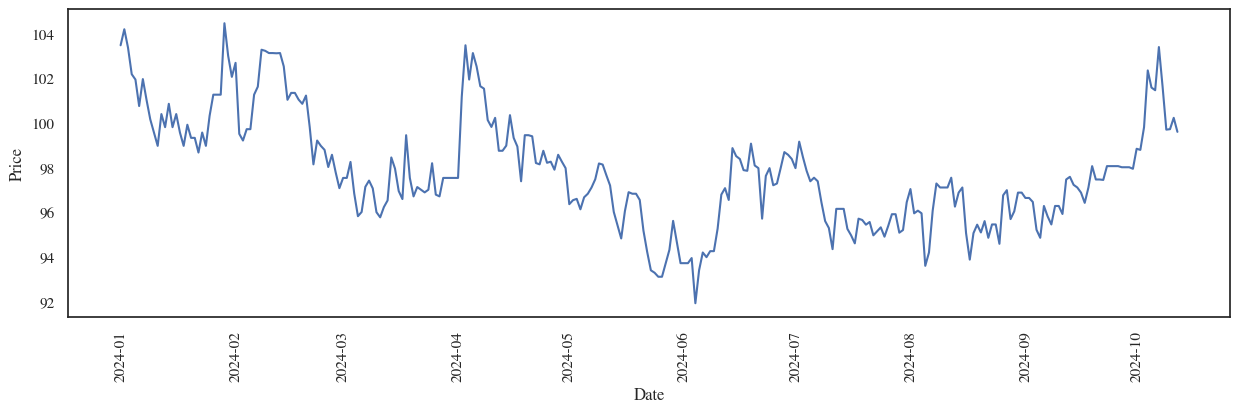

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
sns.lineplot(data=df, x="Date", y="Price", ax=axes)
axes.tick_params(axis="x", labelrotation=90)
plt.show()

# Scale price variable with its max value

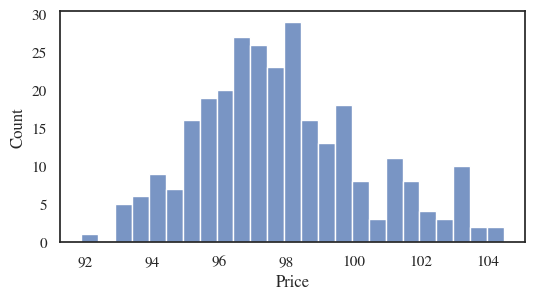

In [151]:
y = df["Price"]# / df["Price"].max()

fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(y, bins = 25)
plt.show()

In [152]:
y = y.reset_index(drop=True)
y

0      103.49
1      104.21
2      103.38
3      102.19
4      101.95
        ...  
281    101.63
282     99.70
283     99.72
284    100.23
285     99.60
Name: Price, Length: 286, dtype: float64

# Train Test Split

In [153]:
from typing import Union

def train_test_split(y, last_k_percent: Union[int, float] = 0.2):
    """Function to split X and y to train and test sets, where the last k percent is used for the testing.

    :param y: pd.DataFrame -- Labels
    :param last_k_percent: Union[int, float] -- Last k percent, or last k days
    :return: X_train, y_train, X_test, y_test, k
    """
    N = len(y)
    if isinstance(last_k_percent, float):
        # Get last k percent as absolute value
        k = int(N * last_k_percent)
    else:
        k = last_k_percent

    # Get first N-k values, e.g. first 250 values
    y_train = y.iloc[:(N-k)]
    # Get last k values, e.g. last 50 values
    y_test = y.iloc[-k:]

    return y_train, y_test, k


y_train, y_test, k = train_test_split(y=y, last_k_percent=0.1)

In [154]:
y_train_indices = y_train.index
y_test_indices = y_test.index

# Normaling to [0, 1]

In [155]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

print(y_train_scaled.shape)
print(y_test_scaled.shape)

(258, 1)
(28, 1)


In [156]:
import torch

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, y_train = split_sequence(y_train_scaled.tolist(), n_steps_in=21, n_steps_out=7)
X_test, y_test = split_sequence(y_test_scaled.tolist(), n_steps_in=21, n_steps_out=7)

# Target Shape: [Batch_Size, N_Timesteps, N_Features]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_train.shape)

(231, 21, 1)
(231, 7, 1)
(1, 21, 1)
(231, 7, 1)


# Modelling

In [157]:
from torch.utils.data import DataLoader, Dataset

class CustomLSTMDataset(Dataset):
    def __init__(self, X: np.array, y: np.array):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 4
SHUFFLE = False

train_data = CustomLSTMDataset(X_train, y_train)
test_data = CustomLSTMDataset(X_test, y_test)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

x, y = next(iter(train_dataloader))
print(x.shape)
print(y.shape)

torch.Size([4, 21, 1])
torch.Size([4, 7, 1])


In [158]:
y_train.shape

(231, 7, 1)

In [159]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from src.modelling.lightning_model import PLModel

tb_logger = TensorBoardLogger("tb_logs", "OilPreds")

model = PLModel(n_timesteps=X_train.shape[1],
                n_features=X_train.shape[2],
                n_target_steps=y_train.shape[1])

trainer = pl.Trainer(max_epochs=8,
                     fast_dev_run=False,
                     logger=tb_logger)

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | model   | PredictorModel | 288    | train
1 | loss_fn | MSELoss        | 0      | train
---------------------------------------------------
288       Trainable params
0         Non-trainable params
288       Total params
0.001     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/alessionegrini/PycharmProjects/bfh24/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/Users/alessionegrini/PycharmProjects/bfh24/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


In [160]:
y_pred = trainer.predict(model=model, dataloaders=val_dataloader)
y_pred

/Users/alessionegrini/PycharmProjects/bfh24/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

[tensor([[[0.4005],
          [0.4017],
          [0.4082],
          [0.4108],
          [0.4183],
          [0.4356],
          [0.4383]]], dtype=torch.float64)]

In [161]:
y_pred_scaled_back = scaler.inverse_transform(y_pred[0].flatten().reshape(-1,1))
y_pred_scaled_back

array([[96.93876957],
       [96.95338159],
       [97.03498548],
       [97.06747347],
       [97.16226329],
       [97.38000793],
       [97.41384543]])

In [162]:
y_train_scaled_back = scaler.inverse_transform(y_train_scaled).reshape(-1, 1)
y_train_scaled_back

array([[103.49],
       [104.21],
       [103.38],
       [102.19],
       [101.95],
       [100.76],
       [101.97],
       [101.03],
       [100.16],
       [ 99.57],
       [ 98.97],
       [100.4 ],
       [ 99.81],
       [100.86],
       [ 99.81],
       [100.4 ],
       [ 99.57],
       [ 98.97],
       [ 99.92],
       [ 99.33],
       [ 99.33],
       [ 98.67],
       [ 99.57],
       [ 98.97],
       [100.32],
       [101.27],
       [101.27],
       [101.27],
       [104.48],
       [103.02],
       [102.07],
       [102.7 ],
       [ 99.51],
       [ 99.21],
       [ 99.72],
       [ 99.72],
       [101.27],
       [101.63],
       [103.29],
       [103.24],
       [103.14],
       [103.14],
       [103.13],
       [103.14],
       [102.54],
       [101.04],
       [101.35],
       [101.35],
       [101.05],
       [100.86],
       [101.23],
       [ 99.81],
       [ 98.14],
       [ 99.21],
       [ 98.97],
       [ 98.79],
       [ 98.02],
       [ 98.57],
       [ 97.78

<Axes: xlabel='None'>

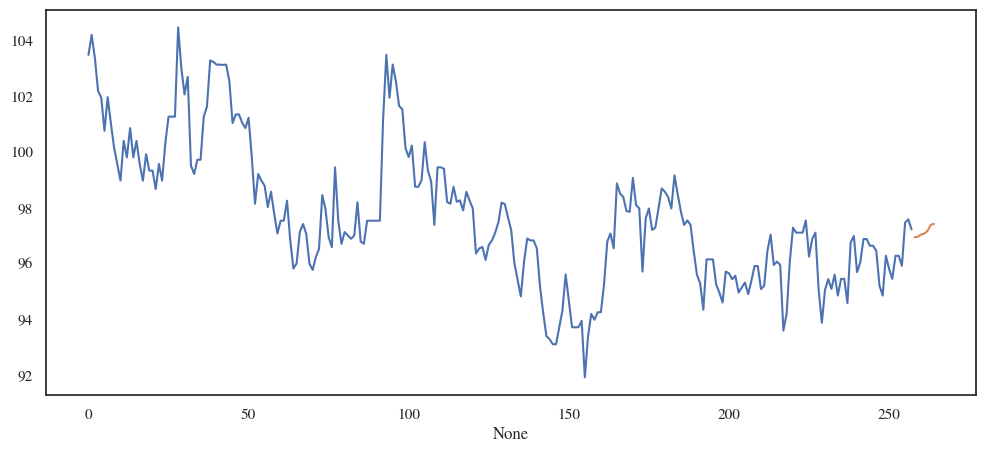

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
sns.lineplot(x=y_train_indices, y=y_train_scaled_back.flatten(), ax=axes)
sns.lineplot(x=y_test_indices[:len(y_pred_scaled_back)], y=y_pred_scaled_back.flatten(), ax=axes)